# Function approximation

## 切比雪夫多项式零点插值逼近

In [1]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file_name:chebyshev_zero_points_interp.py
@IDE:PyCharm  Python: 3.9.7
@copyright: http://maths.xynu.edu.cn
"""
import numpy as np
import sympy
from interpolation_02.lagrange_interpolation import LagrangeInterpolation  # 拉格朗日插值
from util_font import *


class ChebyshevZeroPointsInterpolation:
    """
    切比雪夫多项式零点插值算法
    """
    terms_zeros = None  # 切比雪夫多项式零点
    approximation_poly = None  # 逼近的多项式
    poly_coefficient, polynomial_orders = None, None  # 逼近多项式的系数，各项阶次
    max_abs_error, mae = None, None  # 逼近多项式的最大绝对值误差，绝对误差均值mae

    def __init__(self, approximate_fx, orders=6, x_span=np.array([-1, 1])):
        """
        必要参数的初始化
        """
        self.approximate_fx = approximate_fx
        self.orders = int(orders)  # 插值最高阶次
        self.a, self.b = x_span[0], x_span[1]

    def fit_approximation(self):
        """
        切比雪夫多项式零点插值核心算法：先求零点并变换空间，再进行拉格朗日插值，生成p(x)
        :return:
        """
        k = np.arange(0, self.orders + 1)  # 切比雪夫零点索引下标
        zero = np.cos((2 * k + 1) / 2 / (self.orders + 1) * np.pi)
        self.terms_zeros = (self.b - self.a) / 2 * zero + (self.b + self.a) / 2  # 存储零点，区间变换
        fun_values = self.approximate_fx(self.terms_zeros)  # 零点的函数值
        lag = LagrangeInterpolation(self.terms_zeros, fun_values)  # 拉格朗日插值
        lag.fit_interp()  # 生成拉格朗日插值多项式，符号多项式
        self.approximation_poly = lag.polynomial  # 插值后的逼近多项式
        self.poly_coefficient = lag.poly_coefficient  # 多项式系数
        self.polynomial_orders = lag.coefficient_order  # 多项式的阶次
        self.error_analysis()  # 误差分析

    def predict_x0(self, x0):
        """
        求解逼近多项式p(x)在给定点x0的值
        :return:
        """
        t = self.approximation_poly.free_symbols.pop()  # 提取自由变量
        appr_poly = sympy.lambdify(t, self.approximation_poly)  # 转换为lambda函数
        return np.array(appr_poly(x0))

    def error_analysis(self):
        """
        误差分析：10轮模拟，每轮100个服从U(a,b)的随机点，选取最大绝对误差和计算绝对误差均值
        :return:
        """
        mae = np.zeros(10)  # 存储10次随机值，真值与逼近多项式的均方根误差
        max_error = np.zeros(10)  # 存储10次随机模拟，每次最大的绝对值误差
        for i in range(10):
            xi = self.a + np.random.rand(1000) * (self.b - self.a)
            xi = np.array(sorted(xi))  # list-->ndarray，升序排列
            y_true = self.approximate_fx(xi)  # 真值
            yi_hat = self.predict_x0(xi)  # 预测值
            mae[i] = np.mean(np.abs(yi_hat - y_true))  # 100个随机点的绝对误差均值
            max_error[i] = max(np.abs(yi_hat - y_true))  # 100个随机点选最大的绝对值误差
            idx = np.argmax(np.abs(yi_hat - y_true))
            # print(i, ":", xi[idx], np.abs(yi_hat - y_true)[idx])
        self.max_abs_error = max(max_error)  # 10次模拟选最大的
        self.mae = np.mean(mae)  # 10次模拟均值

    def plt_approximation(self, is_show=True, is_fh_marker=False):
        """
        可视化逼近多项式。针对被逼近函数，如果is_fh_marker为True，则随机化50个点，并标记
        :param is_show: 用于绘制子图，如果绘制子图，则值为False
        :param is_fh_marker: 真实函数是曲线类型还是marker类型
        """
        if is_show:
            plt.figure(figsize=(7, 5))
        xi = np.linspace(self.a, self.b, 200)
        yi_hat = self.predict_x0(xi)  # 求解模拟点
        plt.plot(xi, yi_hat, "r-", lw=2, label="$p(x) \ (k=%d)$" % self.orders)
        if is_fh_marker:
            xi = self.a + np.random.rand(50) * (self.b - self.a)
            xi = np.array(sorted(xi))  # list-->ndarray，升序排列
            y_true = self.approximate_fx(xi)
            plt.plot(xi, y_true, "k*", label="$f(x_k), \ x_k \sim U(a, b)$")
        else:
            y_true = self.approximate_fx(xi)
            plt.plot(xi, y_true, "k--", lw=2, label="$f(x)$")
        plt.xlabel(r"$x$", fontdict={"fontsize": 18})
        plt.ylabel(r"$f(x) \ / \ p(x)$", fontdict={"fontsize": 18})
        plt.tick_params(labelsize=16)  # 刻度字体大小16
        # mse_10的含义为10次随机绝对误差均值
        plt.title("切比雪夫零点插值逼近$(MAE_{10}=%.2e)$" % self.mae, fontdict={"fontsize": 18})
        plt.legend(frameon=False, fontsize=18, loc="best")  # loc="upper left"
        plt.grid(ls=":")
        if is_show:
            plt.show()


最大逼近多项式绝对值误差： 2.896635244953316e-05
零点值： [0.97552826 0.79389263 0.5        0.20610737 0.02447174]
拉格朗日插值逼近多项式系数以及阶次：
[0.0694155133774643, 0.140275036852586, 0.509779835305423, 0.998757050931840, 1.00002493721519]
[(4,), (3,), (2,), (1,), (0,)]
4 1.7132826188981776e-05
5 7.174404489271202e-07
6 2.5315462818609195e-08
7 7.996443731617122e-10
8 2.3806411775240122e-11
9 6.763407811583022e-12
10 1.3130480169820658e-11
11 9.82234821123029e-10
12 1.7512083990034454e-09
13 2.2913325134621407e-08
14 9.78835389652044e-08
15 6.547535677100981e-07
16 7.110345920500083e-06


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

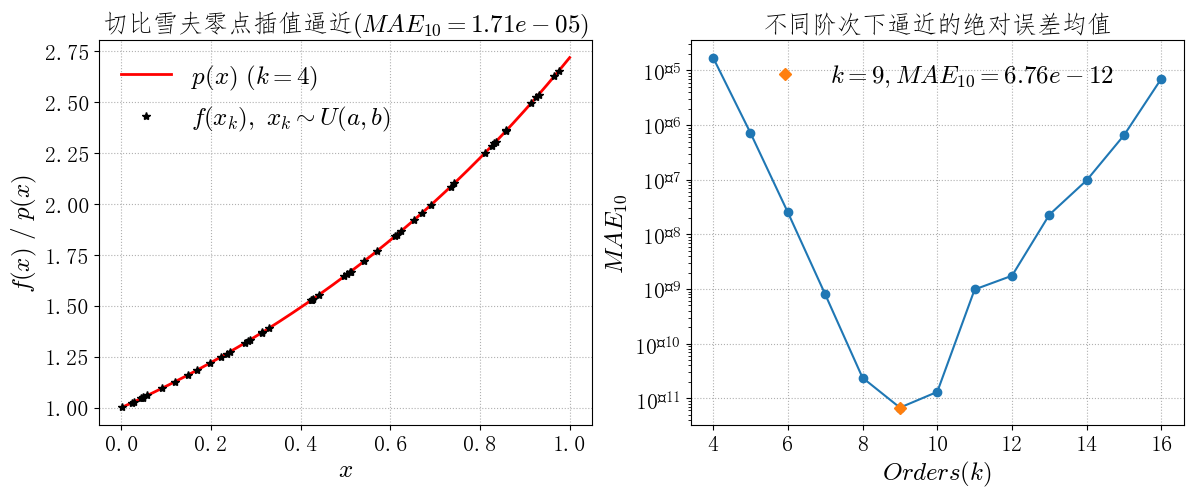

In [2]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file_name:test_chebyshev_zero_interp.py
@IDE: PyCharm  Python: 3.9.7
@copyright: http://maths.xynu.edu.cn
"""

import numpy as np
import matplotlib.pyplot as plt
from function_approximation_03.chebyshev_zero_points_interp import ChebyshevZeroPointsInterpolation

# import matplotlib as mpl
# from matplotlib import font_manager

# # 指定中文字体路径（确保路径正确）
# font_path = "/usr/share/fonts/winfonts/simfang.ttf"
# zh_font = font_manager.FontProperties(fname=font_path)

# # 设置字体和数学字体
# mpl.rcParams["font.family"] = zh_font.get_name()
# mpl.rcParams["axes.unicode_minus"] = False
# plt.rcParams["mathtext.fontset"] = "cm"

# 例1测试代码
fun = lambda x: np.exp(x)  # 被逼近函数
plt.figure(figsize=(14, 5))
czpi = ChebyshevZeroPointsInterpolation(fun, orders=4, x_span=[0, 1])
czpi.fit_approximation()
print("最大逼近多项式绝对值误差：", czpi.max_abs_error)
print("零点值：", czpi.terms_zeros)
print("拉格朗日插值逼近多项式系数以及阶次：")
print(czpi.poly_coefficient)
print(czpi.polynomial_orders)
plt.subplot(121)
czpi.plt_approximation(is_show=False, is_fh_marker=True)
orders = np.linspace(4, 16, 13, dtype=int)
mae = []
for k in orders:
    czpi = ChebyshevZeroPointsInterpolation(fun, orders=k, x_span=[0, 1])
    czpi.fit_approximation()
    mae.append(czpi.mae)
    print(k, czpi.mae)
plt.subplot(122)
plt.plot(orders, mae, "o-")
idx = np.argmin(mae)
plt.semilogy(orders[idx], mae[idx], "D", label="$k=%d, MAE_{10}=%.2e$" % (orders[idx], mae[idx]))
plt.legend(frameon=False, fontsize=18)
plt.xlabel("$Orders(k)$", fontsize=18)
plt.ylabel("$MAE_{10}$", fontsize=18)
plt.tick_params(labelsize=16)
plt.grid(ls=":")
plt.title("不同阶次下逼近的绝对误差均值", fontsize=18)
plt.show()

fun2 = lambda x: 1 / (1 + x ** 2)  # 龙格函数
fun3 = lambda x: np.tan(np.cos((np.sqrt(3) + np.sin(2 * x)) / (3 + 4 * x ** 2)))  # 被逼近函数

# 例2测试代码
# fun4 = lambda x: np.sin(2 * x) ** 2 * np.exp(-0.5 * x)
# plt.figure(figsize=(14, 5))
# czpi = ChebyshevZeroPointsInterpolation(fun4, orders=10, x_span=[-3, 3])
# czpi.fit_approximation()
# print("最大逼近多项式绝对值误差：", czpi.max_abs_error)
# print("零点值：", czpi.terms_zeros)
# print("拉格朗日插值逼近多项式系数以及阶次：")
# print(czpi.poly_coefficient)
# print(czpi.polynomial_orders)
# plt.subplot(121)
# czpi.plt_approximation(is_show=False)
#
# czpi = ChebyshevZeroPointsInterpolation(fun4, orders=20, x_span=[-3, 3])
# czpi.fit_approximation()
# print("最大逼近多项式绝对值误差：", czpi.max_abs_error)
# print("零点值：", czpi.terms_zeros)
# print("拉格朗日插值逼近多项式系数以及阶次：")
# print(czpi.poly_coefficient)
# print(czpi.polynomial_orders)
# plt.subplot(122)
# czpi.plt_approximation(is_show=False, is_fh_marker=True)
# plt.show()




## 切比雪夫级数逼近

In [1]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file:orthogonal_polynomial_ls_fitting.py
@IDE:PyCharm  Python: 3.9.7
@copyright: http://maths.xynu.edu.cn
"""
import numpy as np
import sympy
from util_font import *


class OrthogonalPolynomialLSFitting:
    """
    正交多项式最小二乘拟合：p(x) = a0*P0(x) + a1*P1(x) + ... + an*Pn(x)
    """
    fit_polynomial = None  # 正交多项式最小二乘拟合的多项式
    poly_coefficient, polynomial_orders = None, None  # 多项式系数和各项阶次
    fit_error, mse = None, np.inf  # 拟合误差向量, 拟合均方误差mse

    def __init__(self, x, y, k, w=None):  # 参考最小二乘多项式拟合
        self.x, self.y = np.asarray(x, dtype=np.float64), np.asarray(y, dtype=np.float64)
        self.k = k  # 正交多项式最小二乘拟合的最高阶次
        if len(self.x) != len(self.y):
            raise ValueError("数据点坐标不匹配！")
        else:
            self.n = len(self.x)
        if w is None:
            self.w = np.ones(self.n)  # 初始权重为1
        else:
            self.w = np.asarray(w, dtype=np.float64)
            if len(self.w) != self.n:
                raise ValueError("权重系数维度与坐标点维度不匹配！")

    def fit_orthogonal_poly(self):
        """
        正交多项式最小二乘曲线拟合核心算法
        :return:
        """
        t = sympy.Symbol("t")  # 正交多项式的符号变量
        self.poly_coefficient = np.zeros(self.k + 1)  # 正交多项式系数a
        px = sympy.Matrix.zeros(self.k + 1, 1)  # 带权正交多项式
        sw = np.sum(self.w)  # 实验数据的权重和
        wy = self.w * self.y  # 权重w_i与y_i的对应元素相乘
        wx = self.w * self.x  # 权重w_i与x_i的对应元素相乘
        # 1. 构造正交多项式的前两项
        alpha = wx.sum() / sw  # alpha_1
        px[0], px[1] = 0 * t + 1, t - alpha  # 正交多项式前两项
        self.poly_coefficient[0] = wy.sum() / sw  # a0
        p_x0 = np.ones(self.n)  # 正交多项式的函数值P(x_i)
        p_x1 = sympy.lambdify(t, px[1], "numpy")(self.x)  # P(x_{i+1})
        self.poly_coefficient[1] = (wy * p_x1).sum() / \
                                   (self.w * p_x1 ** 2).sum()  # a1
        wp = (self.w * p_x1 ** 2).sum()  # alpha和beta子项
        # 2. 从第三项开始，逐步递推构造
        for k in range(2, self.k + 1):
            alpha = (wx * p_x1 ** 2).sum() / wp  # 参数公式
            beta = wp / (self.w * p_x0 ** 2).sum()  # 参数公式
            # 基函数的递推公式
            px[k] = sympy.simplify((t - alpha) * px[k - 1] - beta * px[k - 2])
            p_x0 = np.copy(p_x1)  # P(xi)值的更替
            p_x1 = sympy.lambdify(t, px[k], "numpy")(self.x)  # 新值
            wp = (self.w * p_x1 ** 2).sum()  # alpha和beta子项
            self.poly_coefficient[k] = (wy * p_x1).sum() / wp  # 系数
        # 3. 正交多项式的构造
        self.fit_polynomial = self.poly_coefficient[0] * px[0]
        for k in range(1, self.k + 1):
            self.fit_polynomial += self.poly_coefficient[k] * px[k]
        polynomial = sympy.Poly(self.fit_polynomial, t)
        self.polynomial_orders = polynomial.monoms()[::-1]  # 阶次，从低到高
        # 4. 计算误差
        self.cal_fit_error()

    def predict_x0(self, x0):  # 参考最小二乘多项式拟合
        """
        求解逼近多项式给定点的值
        :return:
        """
        t = self.fit_polynomial.free_symbols.pop()
        fit_poly = sympy.lambdify(t, self.fit_polynomial, "numpy")
        return fit_poly(x0)

    def cal_fit_error(self):  # 参考最小二乘多项式拟合
        """
        计算拟合的误差和均方根误差
        :return:
        """
        self.fit_error = self.y - self.predict_x0(self.x)
        self.mse = np.mean(self.fit_error ** 2)
        return self.mse

    def plt_curve_fit(self, is_show=True):  # 参考最小二乘多项式拟合
        """
        可视化
        :return:
        """
        xi = np.linspace(min(self.x), max(self.x), 100, endpoint=True)
        yi = self.predict_x0(xi)
        if is_show:
            plt.figure(figsize=(7, 5))
        plt.plot(xi, yi, "k-", lw=1.5, label="$p(x):\ k=%d$" % self.k)
        plt.plot(self.x, self.y, "ro", label="$(x_k, y_k)$")
        plt.grid(ls=":")
        plt.legend(frameon=False, fontsize=18)
        plt.tick_params(labelsize=16)  # 刻度字体大小16
        plt.xlabel("$x$", fontdict={"fontsize": 18})
        plt.ylabel("$y$", fontdict={"fontsize": 18})
        plt.title("正交多项式曲线拟合$(MSE = %.2e)$" % self.mse, fontdict={"fontsize": 18})
        if is_show:
            plt.show()


In [3]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file:chebyshev_series_approximation.py
@IDE:PyCharm  Python: 3.9.7
@copyright: http://maths.xynu.edu.cn
"""
import sympy
import numpy as np
from scipy import integrate
from function_approximation_03.utils.orthogonal_poly_utils import OrthogonalPolynomialUtils


class ChebyshevSeriesApproximation(OrthogonalPolynomialUtils):
    """
    切比雪夫级数逼近函数，继承OrthogonalPolynomialUtils
    """

    def fit_approximation(self):
        """
        逼近核心算法，即求解系数和递推项
        :return:
        """
        t = self.fun_transform.free_symbols.pop()
        term = sympy.Matrix.zeros(self.k + 1, 1)
        term[0], term[1] = 1, t  # 初始第一、二项
        coefficient = np.zeros(self.k + 1)  # 存储系数
        # 符号函数构造为lambda函数，以便积分运算
        expr = sympy.lambdify(t, self.fun_transform / sympy.sqrt(1 - t ** 2))
        coefficient[0] = integrate.quad(expr, -1, 1)[0] * 2 / np.pi  # 数值积分
        expr = sympy.lambdify(t, term[1] * self.fun_transform /
                              sympy.sqrt(1 - t ** 2))
        coefficient[1] = integrate.quad(expr, -1, 1)[0] * 2 / np.pi
        self.approximation_poly = coefficient[0] / 2 + coefficient[1] * term[1]  # 多项式的前两项
        # 从第三项开始循环求解
        for i in range(2, self.k + 1):
            term[i] = sympy.simplify(2 * t * term[i - 1] - term[i - 2])
            expr = sympy.lambdify(t, term[i] * self.fun_transform /
                                  sympy.sqrt(1 - t ** 2))
            iv = integrate.quad(expr, -1, 1, full_output=1, points=(-1, 1))[0]
            coefficient[i] = 2 / np.pi * iv  # 系数
            self.approximation_poly += coefficient[i] * term[i]

        self.T_coefficient = [term, coefficient]  # 存储逼近多项式各项和对应系数
        self.approximation_poly = sympy.simplify(self.approximation_poly)
        polynomial = sympy.Poly(self.approximation_poly, t)
        self.poly_coefficient = polynomial.coeffs()
        self.polynomial_orders = polynomial.monoms()
        OrthogonalPolynomialUtils.error_analysis(self)  # 调用父类函数

    def plt_approximate(self, is_show=True, is_fh_marker=False):
        """
        可视化函数和逼近多项式函数
        :return:
        """
        OrthogonalPolynomialUtils.plt_approximation(self, "切比雪夫级数", is_show, is_fh_marker)


切比雪夫多项式零点插值逼近最大绝对值误差是： 0.1091533998434231
切比雪夫级数逼近最大绝对值误差是： 0.11022826153411935
勒让德级数逼近最大绝对值误差是： 0.10057521367623101
切比雪夫多项式零点插值逼近最大绝对值误差是： 0.011414953988865939
切比雪夫级数逼近最大绝对值误差是： 0.006827010075543427
勒让德级数逼近最大绝对值误差是： 0.00772402022097219


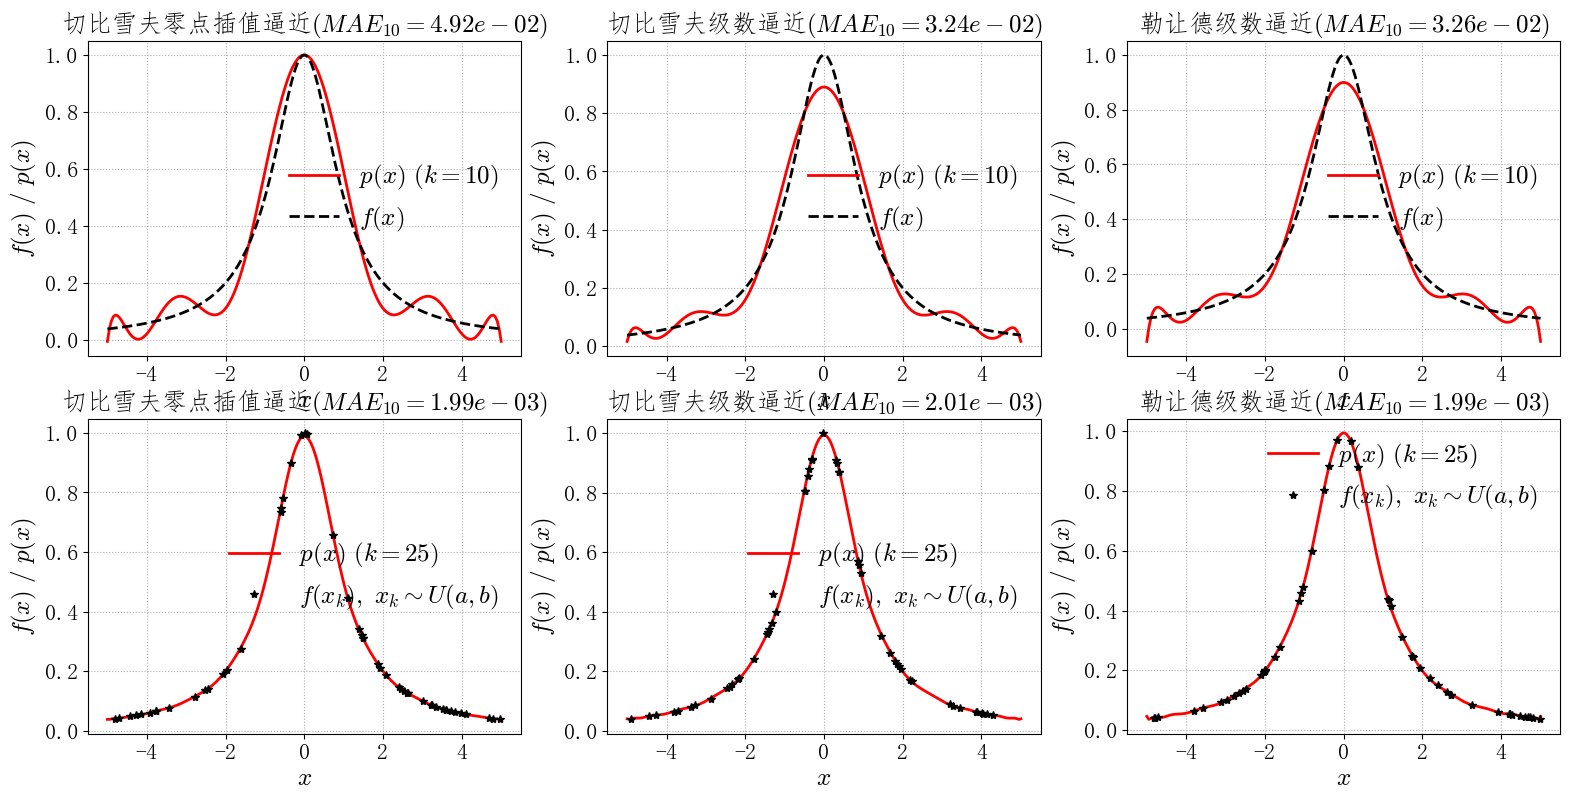

In [4]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file_name:test_chebyshev_legendre.py
@copyright: http://maths.xynu.edu.cn
"""

import sympy
from function_approximation_03.chebyshev_zero_points_interp import ChebyshevZeroPointsInterpolation
from function_approximation_03.chebyshev_series_approximation import ChebyshevSeriesApproximation
from function_approximation_03.legendre_series_approximation import LegendreSeriesApproximation
import matplotlib.pyplot as plt
import numpy as np

t = sympy.Symbol("t")
runge_fun, sym_fun = lambda x: 1 / (x ** 2 + 1), 1 / (t ** 2 + 1)  # 龙格函数
fun = lambda x: np.sin(2 * x + np.pi / 6) * np.exp(-0.4 * x)
plt.figure(figsize=(19, 9))
for i, order in enumerate([10, 25]):
    plt.subplot(231 + 3 * i)  # 321, 322
    czpi = ChebyshevZeroPointsInterpolation(runge_fun, x_span=[-5, 5], orders=order)
    czpi.fit_approximation()
    if i == 0:
        czpi.plt_approximation(is_show=False)
    else:
        czpi.plt_approximation(is_show=False, is_fh_marker=True)
    print("切比雪夫多项式零点插值逼近最大绝对值误差是：", czpi.max_abs_error)
    print("=" * 70)
    plt.subplot(232 + 3 * i)  # 323, 324
    csa = ChebyshevSeriesApproximation(sym_fun, x_span=[-5, 5], k=order)
    csa.fit_approximation()
    if i == 0:
        csa.plt_approximate(is_show=False)
    else:
        csa.plt_approximate(is_show=False, is_fh_marker=True)
    print("切比雪夫级数逼近最大绝对值误差是：", csa.max_abs_error)
    print("=" * 70)
    plt.subplot(233 + 3 * i)  # 325, 326
    lsa = LegendreSeriesApproximation(sym_fun, x_span=[-5, 5], k=order)
    lsa.fit_approximation()
    if i == 0:
        lsa.plt_approximate(is_show=False)
    else:
        lsa.plt_approximate(is_show=False, is_fh_marker=True)
    print("勒让德级数逼近最大绝对值误差是：", lsa.max_abs_error)
plt.show()

